In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# These are the default parameters used by the models.

# Population count. It is constant over the experience.
N: int = 100
# The transmission parameter.
beta: float = 0.02
# The recovery rate. Used in the SIS model (the last one).
gamma: float = 0.006
# Initial infected people. Must be <= N.
I0: int = 3
# Number of days to simulate in the experience.
t_max: int = 365 * 2 # one year

In [59]:
# Sanity checks.
assert(N > 0)
assert(beta >= 0)
assert(gamma >= 0)
assert(I0 <= N and I0 >= 0)
assert(t_max > 0)

In [60]:
# Do we show the S = (N - I) curve?
SHOW_S_CURVE = True
# Do we save the figures to SVG files? Only used when creating the report.
SAVE_FIGURES = False

def show_plot(I, title = "", asymptote: bool = False, fname: str | None = None, annotate_middle: bool = False):
    t = np.arange(0, len(I))
    
    plt.xlabel("Time (in days)")
    plt.ylabel("Infected people")
    plt.plot(t, I, label="Infected people")
    if SHOW_S_CURVE:
        plt.plot(t, N - I, label="Healthy people")
    plt.title(title)

    if asymptote:
        max: float = I[-1]
        plt.axhline(max, ls='--')

    # This add the coordinates of the intersection between the curves I and S.
    if annotate_middle:
        idx = np.argwhere(np.diff(np.sign((I) - (N - I)))).flatten()
        plt.annotate(" ({:.4g}, {:.4g})".format(t[idx][0], I[idx][0]), xy=(t[idx], I[idx]))

    plt.legend()
    if fname is not None and SAVE_FIGURES:
        plt.savefig(fname, format='svg')
    plt.show()

## The SI model

The equation:
$$
I_t = I_{t-1} + \beta I_{t-1}
$$

If we factorize, we get:
$$
I_t = \left(1 + \beta\right) I_{t-1}
$$

However, $I_t \xrightarrow{} \infty$, so it may grow over $N$. To avoid that, we clamp it to $N$. Finally, we have the following equation:
$$
I_t = \min(N, \left(1 + \beta\right) I_{t-1})
$$

In [61]:
def si_model(beta: float, N: int = N, I0: int = I0, t_max: int = t_max):
    """
    :param beta: The infection rate.
    :param N: The population count.
    :param I0: The initial infected count.
    :param t_max: The number of days to simulate.
    :returns: The number of infected people at each day.
    """
    
    I = np.zeros(t_max)
    I[0] = I0

    for t in range(1, t_max):
        # We clamp the infected count over N. We can not have more infected 
        # people than total alive people.
        # This just avoid the model to explode, and show a better graph.
        # But it is not exactly the same as described in the paper.
        I[t] = min(N, (1 + beta) * I[t-1])
    
    return I

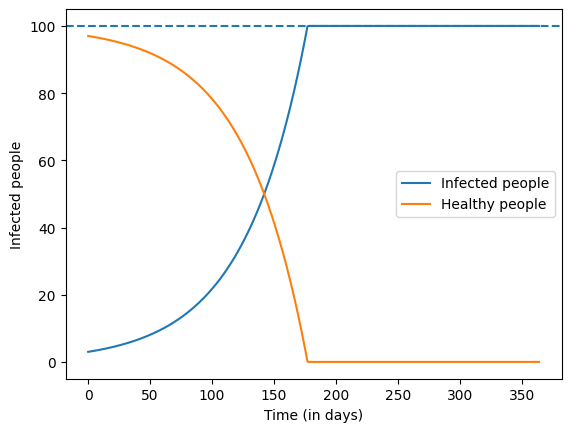

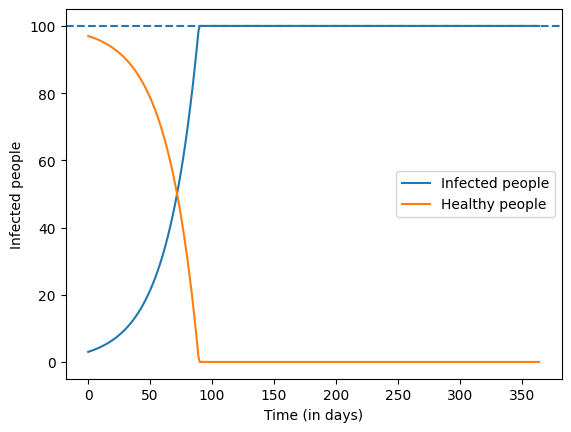

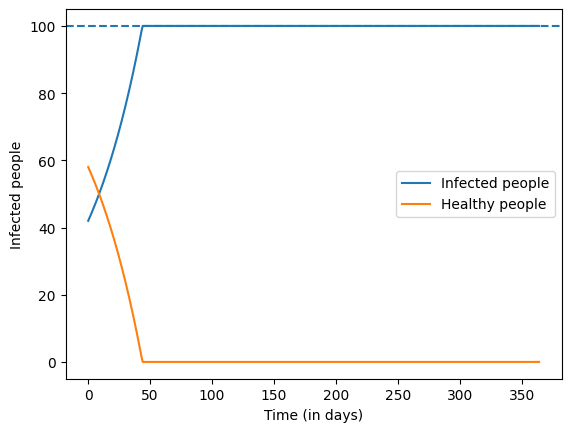

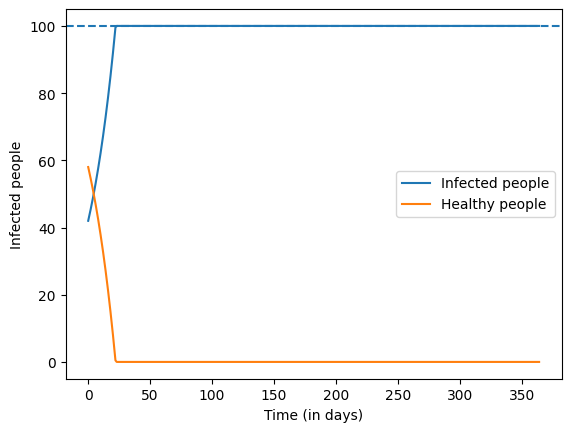

In [62]:
I = si_model(0.02, N, 3, 365)
show_plot(I, asymptote=True, fname="figures/si_002_3.svg")
I = si_model(0.04, N, 3, 365)
show_plot(I, asymptote=True, fname="figures/si_004_3.svg")
I = si_model(0.02, N, 42, 365)
show_plot(I, asymptote=True, fname="figures/si_002_42.svg")
I = si_model(0.04, N, 42, 365)
show_plot(I, asymptote=True, fname="figures/si_004_42.svg")

## The SI model improved

The equation:
$$
I_t = I_{t-1} + \frac{\beta}{N} I_{t-1} S_{t-1}
$$
with $S_{t-1}=N - S_{t-1}$

If we factorize, we get:
$$
I_t = \left(1 + \frac{\beta}{N} (N - I_{t-1})\right) I_{t-1}
$$

In [63]:
# In the two following models, we do not store explictly the S curve.
# It is represented implictly as N - I. This avoid storing excessive useless data.

def si_improved_model(beta: float, N: int = N, I0: int = I0, t_max: int = t_max):
    """
    :param beta: The infection rate.
    :param N: The population count.
    :param I0: The initial infected count.
    :param t_max: The number of days to simulate.
    :returns: The number of infected people at each day.
    """
    
    I = np.zeros(t_max)
    I[0] = I0

    coef: float = beta / N # compute the division once to avoid useless repetition
    for t in range(1, t_max):
        # We use the factorised form to avoid doing useless multiplications
        I[t] = (1 + coef * (N - I[t-1])) * I[t-1]

    return I

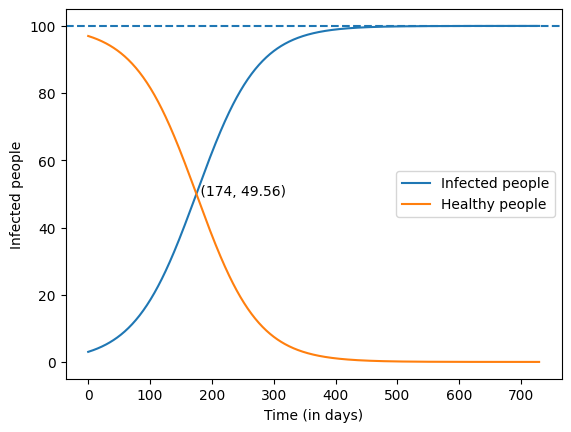

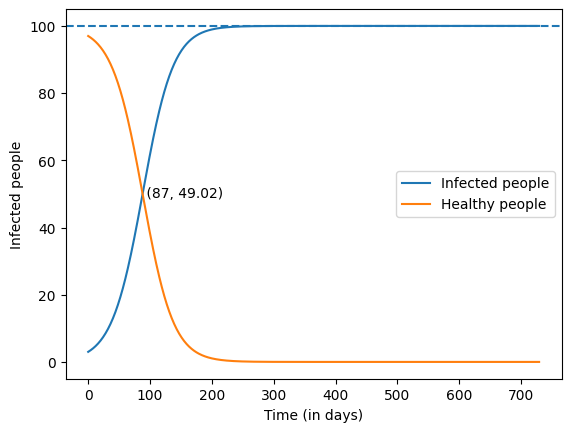

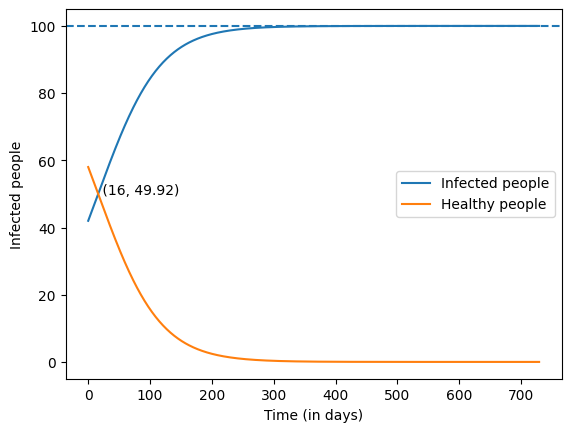

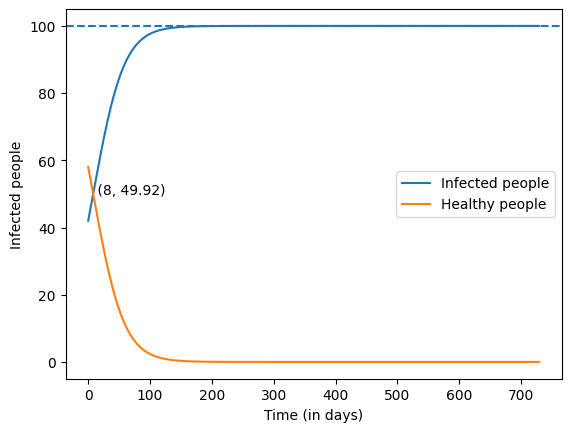

In [64]:
I = si_improved_model(0.02, N, 3, t_max)
show_plot(I, asymptote=True, fname="figures/si_improved_002_3.svg", annotate_middle = True)
I = si_improved_model(0.04, N, 3, t_max)
show_plot(I, asymptote=True, fname="figures/si_improved_004_3.svg", annotate_middle = True)
I = si_improved_model(0.02, N, 42, t_max)
show_plot(I, asymptote=True, fname="figures/si_improved_002_42.svg", annotate_middle = True)
I = si_improved_model(0.04, N, 42, t_max)
show_plot(I, asymptote=True, fname="figures/si_improved_004_42.svg", annotate_middle = True)

## The SIS model

The equation:
$$
I_t = I_{t-1} + \frac{\beta}{N} I_{t-1} S_{t-1} + \gamma I_{t-1}
$$
with $S_{t-1}=N - S_{t-1}$

If we factorize, we get:
$$
I_t = \left(1 + \frac{\beta}{N} (N - I_{t-1}) + \gamma\right) I_{t-1}
$$

In [65]:
def sis_model(beta: float, gamma: float, N: int = N, I0: int = I0, t_max: int = t_max):
    """
    :param beta: The infection rate.
    :param gamma: The recovery rate.
    :param N: The population count.
    :param I0: The initial infected count.
    :param t_max: The number of days to simulate.
    :returns: The number of infected people at each day.
    """

    I = np.zeros(t_max)
    I[0] = I0

    coef: float = beta / N # compute the division once
    for t in range(1, t_max):
        I[t] = (1 + coef * (N - I[t-1]) - gamma) * I[t-1]

    return I

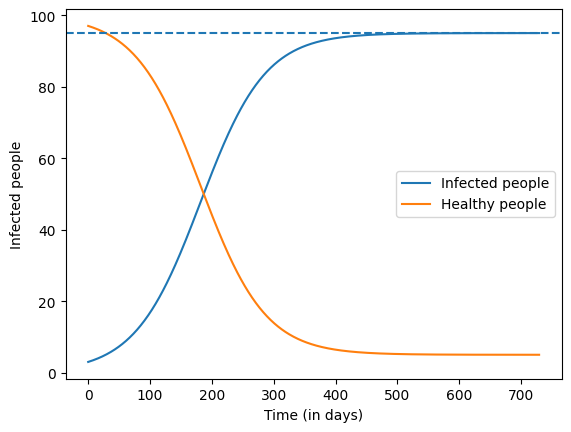

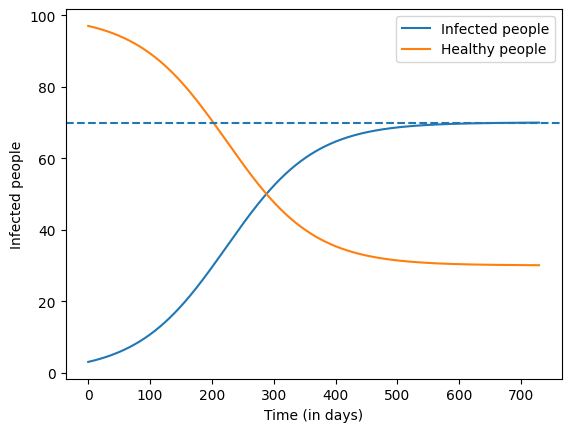

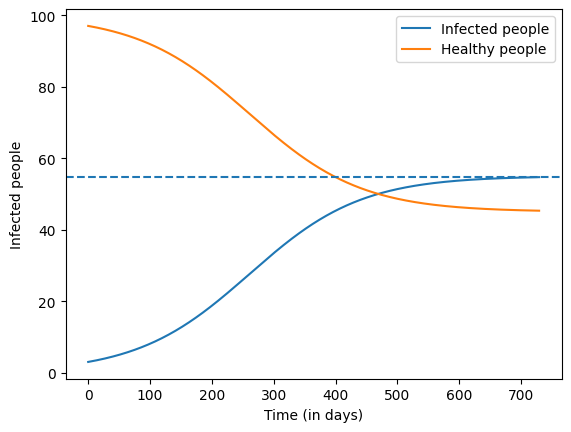

In [66]:
I = sis_model(beta, 0.001)
show_plot(I, asymptote=True, fname="figures/sis_1.svg")
I = sis_model(beta, 0.006)
show_plot(I, asymptote=True, fname="figures/sis_6.svg")
I = sis_model(beta, 0.009)
show_plot(I, asymptote=True, fname="figures/sis_9.svg")

### Different $\sigma$

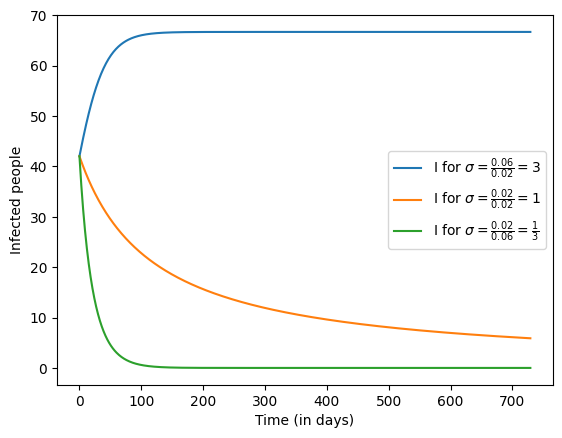

In [67]:
def show_sigma_influence(beta: float, gamma: float, asymptote: bool = False) -> None:
    show_plot(sis_model(beta, gamma), "SIS Model with $\\sigma = \\frac{{ {} }}{{ {} }} = {}$".format(beta, gamma, beta / gamma), asymptote=asymptote)

t = np.arange(0, len(I))
    
plt.xlabel("Time (in days)")
plt.ylabel("Infected people")
plt.plot(t, sis_model(0.06, 0.02, I0=42), label=r"I for $\sigma=\frac{0.06}{0.02}=3$")
plt.plot(t, sis_model(0.02, 0.02, I0=42), label=r"I for $\sigma=\frac{0.02}{0.02}=1$")
plt.plot(t, sis_model(0.02, 0.06, I0=42), label=r"I for $\sigma=\frac{0.02}{0.06}=\frac{1}{3}$")
plt.legend()
if SAVE_FIGURES:
    plt.savefig(format='svg', fname='figures/sis_sigma.svg')
plt.show()

# show_sigma_influence(0.06, 0.006, asymptote=True)
# show_sigma_influence(0.006, 0.006, asymptote=True)
# show_sigma_influence(0.0006, 0.006, asymptote=True)